In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
data=pd.read_csv('Crime_Clean.csv')

In [4]:
data = data[data['Crime Name1'] != 'Other']
data = data[~(data['Crime Name1'].isnull())]

In [5]:
data['Place'].value_counts()

Street - In vehicle            27251
Residence - Single Family      14706
Residence - Apartment/Condo    14260
Street - Residential           13815
Other/Unknown                  11922
                               ...  
Pawn Shop                         42
Retail - Video Store              30
Nursery                           15
Lake/Waterway                     13
Pedestrian Tunnel                  9
Name: Place, Length: 83, dtype: int64

In [6]:
places = data['Place'].value_counts().loc[lambda x: x > 8000]

top_places = list(places.index.values)

data = data[data['Place'].isin(top_places)]

data['Place'].value_counts()

Street - In vehicle            27251
Residence - Single Family      14706
Residence - Apartment/Condo    14260
Street - Residential           13815
Other/Unknown                  11922
Parking Lot - Residential      11026
Residence - Driveway            8425
Name: Place, dtype: int64

In [7]:
import re

pattern1 = r'.*\s*(ASSAULT)\.*'
pattern2 = r'.*\s*(DRUGS|INFLUENCE)\.*'
pattern3 = r'.*\s*(FRAUD|IDENTITY|FORGERY)\.*'
pattern4 = r'.*\s*(DAMAGE PROPERTY|AUTO)\.*'


for i, rowseries in data.iterrows():
    if re.match(pattern1, data.at[i,'Crime Name3']):
        data.at[i, 'Crime Type'] = 'Assault'
    elif re.match(pattern2, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Drugs/DUI'
    elif re.match(pattern3, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Fraud'
    elif re.match(pattern4, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Property Theft/Damage'
    else:
        data.at[i,'Crime Type'] = 'All Other Offenses'

In [8]:
data['Crime Type'].value_counts()

Property Theft/Damage    29629
Drugs/DUI                26594
All Other Offenses       22559
Fraud                    12347
Assault                  10276
Name: Crime Type, dtype: int64

In [9]:
data2 = data[data['Crime Type'] != 'All Other Offenses']
data2['Crime Type'].value_counts()

Property Theft/Damage    29629
Drugs/DUI                26594
Fraud                    12347
Assault                  10276
Name: Crime Type, dtype: int64

In [10]:
classes = data2['Crime Type'].value_counts()

top_classes = list(classes.index.values)

top_classes = sorted(top_classes)
top_classes

['Assault', 'Drugs/DUI', 'Fraud', 'Property Theft/Damage']

In [11]:
len(data2)

78846

In [12]:
data2['target'] = data2['Crime Type'].astype('category').cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
data2['num_words'] = data2['Place'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
data2['bins'] = pd.cut(data2['num_words'], bins=[0,5,10,15,20], labels=['0-5','5-10','10-15','15-20'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
word_dist = data2.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [16]:
word_dist.head()

,bins,counts
0,0-5,78846
1,5-10,0
2,10-15,0
3,15-20,0


In [17]:
num_class = len(np.unique(data2['target'].values))
y = data2['target'].values

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len=10
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data2['Place'].values)
post_seq = tokenizer.texts_to_sequences(data2['Place'].values)
post_seq_padded = pad_sequences(post_seq,maxlen=max_len)

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(post_seq_padded,y,test_size=0.25)

In [20]:
vocab_size= len(tokenizer.word_index) + 1

In [21]:
inputs = tf.keras.Input(shape=(max_len,))
embedding_layer= tf.keras.layers.Embedding(vocab_size,
                          128,
                          input_length=max_len)(inputs)
x = tf.keras.layers.LSTM(64)(embedding_layer)
x = tf.keras.layers.Dense(64, activation='relu')(x)

predictions = tf.keras.layers.Dense(num_class, activation='softmax')(x)

model = tf.keras.Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])

In [22]:
y= tf.keras.utils.to_categorical(y_train)

In [23]:
len(x_train)

59134

In [24]:
len(x_test)

19712

In [25]:
history = model.fit([x_train],y, batch_size=128, verbose=1, validation_split=0.25,shuffle=True, epochs=10)

Epoch 1/10
347/347 [==============================] - 3s 10ms/step - loss: 0.6615 - acc: 0.7663 - val_loss: 0.5890 - val_acc: 0.7953
Epoch 2/10
347/347 [==============================] - 3s 9ms/step - loss: 0.5916 - acc: 0.8001 - val_loss: 0.5859 - val_acc: 0.8060
Epoch 3/10
347/347 [==============================] - 3s 9ms/step - loss: 0.5893 - acc: 0.8019 - val_loss: 0.5893 - val_acc: 0.7953
Epoch 4/10
347/347 [==============================] - 3s 9ms/step - loss: 0.5904 - acc: 0.8005 - val_loss: 0.5892 - val_acc: 0.8060
Epoch 5/10
347/347 [==============================] - 3s 9ms/step - loss: 0.5895 - acc: 0.8012 - val_loss: 0.5907 - val_acc: 0.7953
Epoch 6/10
347/347 [==============================] - 3s 9ms/step - loss: 0.5892 - acc: 0.8013 - val_loss: 0.5857 - val_acc: 0.8060
Epoch 7/10
347/347 [==============================] - 3s 9ms/step - loss: 0.5898 - acc: 0.8014 - val_loss: 0.5848 - val_acc: 0.8060
Epoch 8/10
347/347 [==============================] - 3s 9ms/step - loss: 0

In [26]:
predictions = model.predict(x_test)

In [29]:
predictions[:,1]

array([0.02273799, 0.9123013 , 0.15522233, ..., 0.15522233, 0.15522233,
       0.9123013 ], dtype=float32)

In [30]:
predictions[:,2]

array([0.88685894, 0.00303745, 0.00373507, ..., 0.00373507, 0.00373507,
       0.00303745], dtype=float32)

In [31]:
y_test2 = tf.keras.utils.to_categorical(y_test)
y_test2[:,1]

array([0., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [32]:
loss, acc = model.evaluate(x_test, y_test2)

616/616 [==============================] - 3s 4ms/step - loss: 0.5832 - acc: 0.8072


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


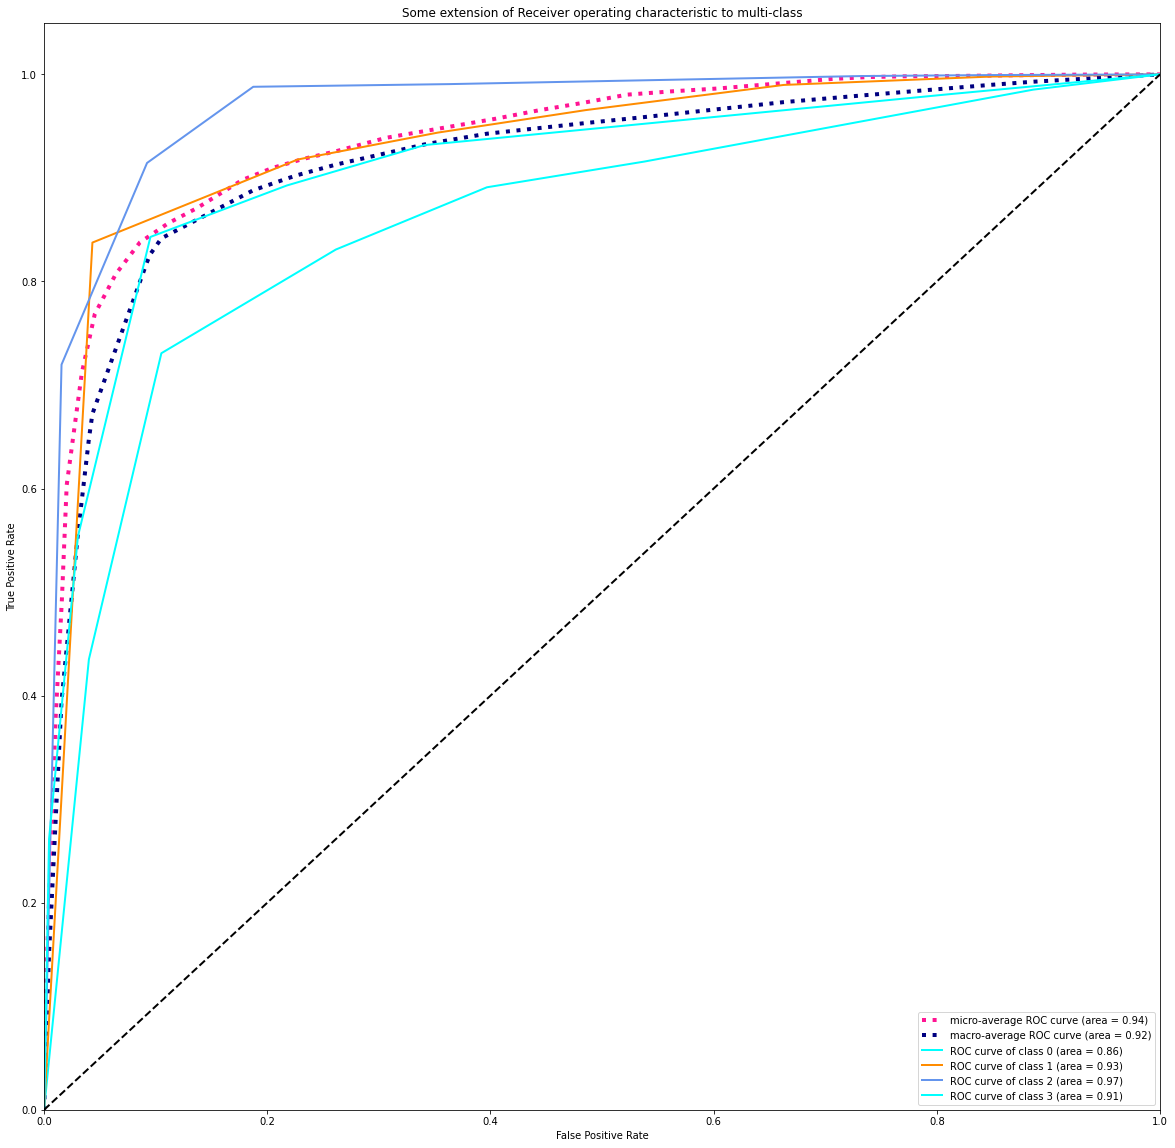

In [33]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(top_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(top_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(top_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(top_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(top_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(20,20)
plt.show()



In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(top_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test2[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test2[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test2.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test2, predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.84


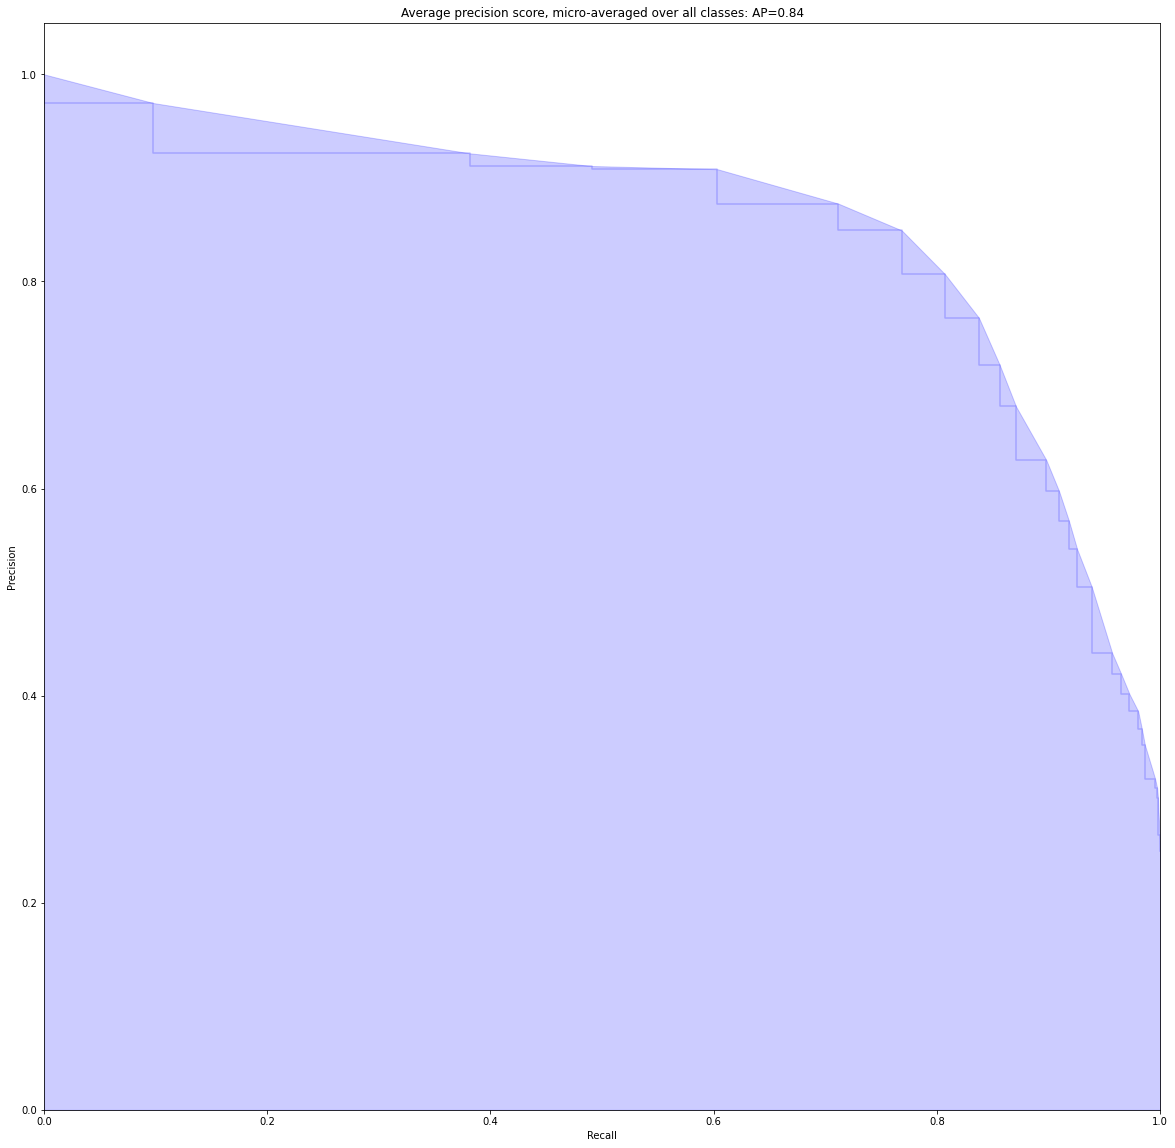

In [35]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
fig = plt.gcf()
fig.set_size_inches(20,20)

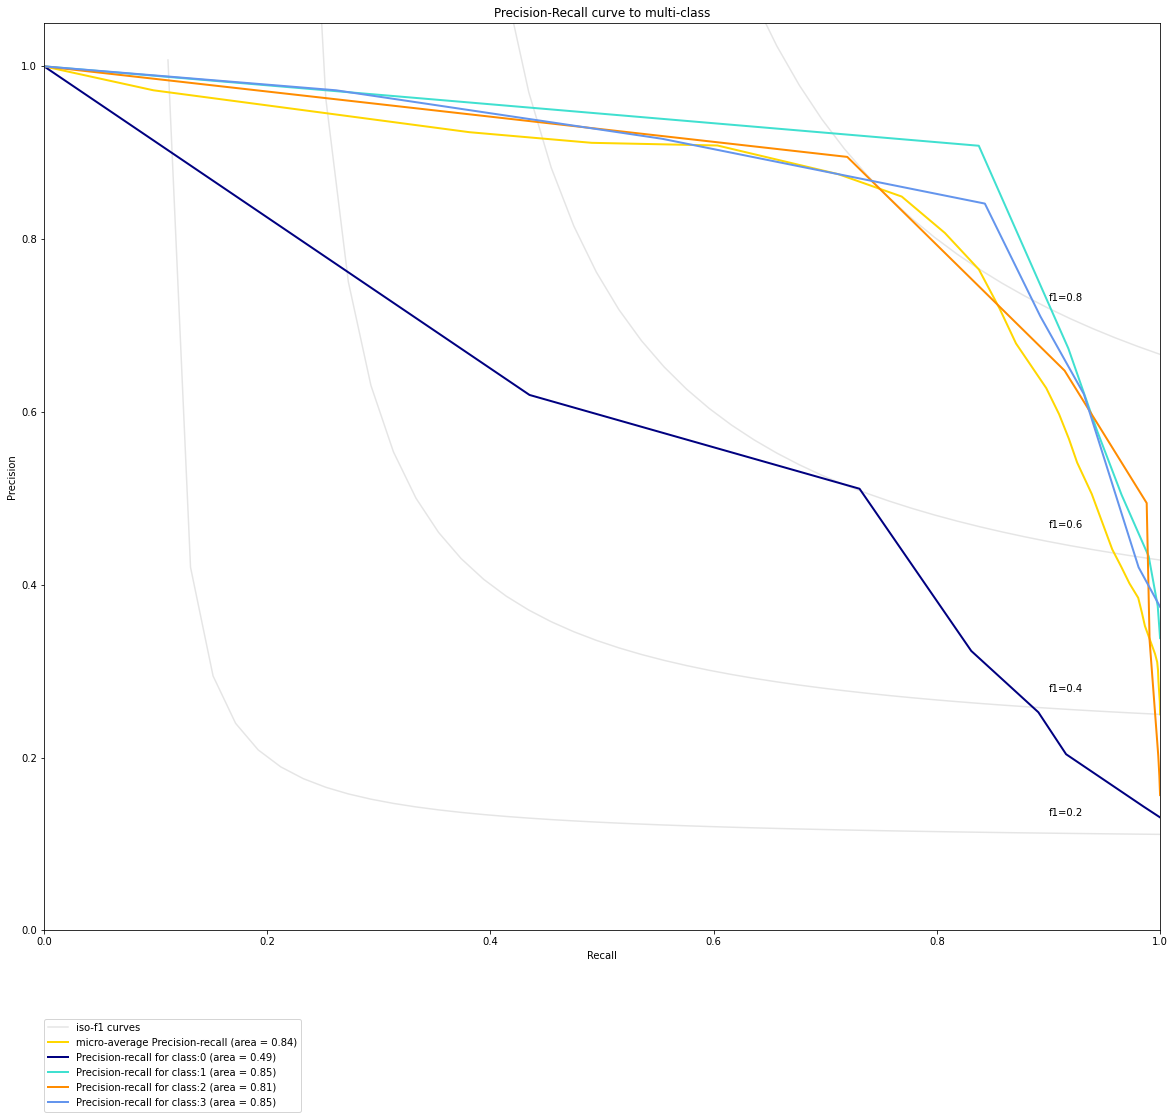

In [36]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(len(top_classes)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))
fig = plt.gcf()
fig.set_size_inches(20,20)

plt.show()

In [37]:
from sklearn.metrics import roc_auc_score

y_prob = model.predict(x_test)

macro_roc_auc_ovo = roc_auc_score(y_test2, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test2, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test2, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test2, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.917027 (macro),
0.920241 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.917027 (macro),
0.920241 (weighted by prevalence)
